In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gammapy.datasets import MapDataset                                                                                                                                     
from gammapy.irf import load_cta_irfs, load_irf_dict_from_file                                                                                                                      
from gammapy.maps import MapAxis, WcsGeom, WcsNDMap                                                                                                                         
from gammapy.modeling.models import (                                                                                                                                       
    FoVBackgroundModel,                                                                                                                                                   
    SkyModel,                                                                                                                                                               
    Models,                                                                                                                                                                 
    TemplateSpatialModel,                                                                                                                                                   
)                                                                                                                                                                           
from gammapy.data import Observation, observatory_locations                                                                                                                 
from gammapy.makers import MapDatasetMaker, SafeMaskMaker                                                                                                                   
from gammapy.astro.darkmatter import profiles, JFactory, DarkMatterAnnihilationSpectralModel                                                                                
from astropy.coordinates import SkyCoord                                                                                                                                    
import astropy.units as u                                                                                                                                                   
import numpy as np                                                                                                                                                                                                                                                                                               
import matplotlib.pyplot as plt       
import os

import astropy.constants as const

from titrate.utils import copy_models_to_dataset

# Validate if asymptotics are valid

quick & ugly generation of a simulation... this is just a copy of conftest.py

In [3]:
def irfs():
    path = (
        f"{os.environ.get('GAMMAPY_DATA')}"
        f"/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    )

    irfs = load_irf_dict_from_file(path)

    return irfs


def observation():
    livetime = 50 * u.hr
    pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
    location = observatory_locations["cta_south"]
    obs = Observation.create(
        pointing=pointing, livetime=livetime, irfs=irfs(), location=location
    )

    return obs


def energy_axes():
    energy_reco = MapAxis.from_edges(
        np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
    )
    energy_axis_true = MapAxis.from_energy_bounds(
        "0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true"
    )
    migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

    return {"true": energy_axis_true, "reco": energy_reco, "migra": migra_axis}


def geometry3d():
    geom = WcsGeom.create(
        skydir=observation().pointing.fixed_icrs,
        width=(4, 4),
        binsz=0.04,
        frame="galactic",
        axes=[energy_axes()["reco"]],
    )

    return geom



def geometry2d():
    geom = WcsGeom.create(
        skydir=observation().pointing.fixed_icrs,
        width=(4, 4),
        binsz=0.04,
        frame="galactic",
    )

    return geom



def ursa_major_ii_profile():
    rhos = (
        10**-1.1331 * const.M_sun.to(u.GeV, equivalencies=u.mass_energy()) / u.pc**3
    )
    rs = 10**3.6317 * u.pc

    profile = profiles.NFWProfile(r_s=rs, rho_s=rhos)
    profile.DISTANCE_GC = 32 * u.kpc

    return profile



def dm_models():
    jfactory = JFactory(
        geom=geometry2d(),
        profile=ursa_major_ii_profile(),
        distance=ursa_major_ii_profile().DISTANCE_GC,
    )
    jfactor = jfactory.compute_differential_jfactor()
    jfact_map = WcsNDMap(geom=geometry2d(), data=jfactor.value, unit=jfactor.unit)
    spatial_model = TemplateSpatialModel(jfact_map, normalize=False)

    spectral_model = DarkMatterAnnihilationSpectralModel(mass=50 * u.TeV, channel="b")

    model_simu = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        name="darkmatter",
    )

    bkg_model = FoVBackgroundModel(dataset_name="foo")

    models = Models([model_simu, bkg_model])

    return models



def measurement_dataset():
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

    empty_measurement = MapDataset.create(
        geometry3d(),
        energy_axis_true=energy_axes()["true"],
        migra_axis=energy_axes()["migra"],
        name="measurement",
    )

    measurement_dataset = maker.run(empty_measurement, observation())
    measurement_dataset = maker_safe_mask.run(measurement_dataset, observation())

    copy_models_to_dataset(dm_models(), measurement_dataset)

    measurement_dataset.models.parameters['scale'].value = 0

    measurement_dataset.fake(random_state=420)

    return measurement_dataset

In [4]:
meas_dataset = measurement_dataset()

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate

In [5]:
print(meas_dataset)

MapDataset
----------

  Name                            : measurement 

  Total counts                    : 2270254 
  Total background counts         : 2272694.54
  Total excess counts             : -2440.54

  Predicted counts                : 2272694.54
  Predicted background counts     : 2272694.54
  Predicted excess counts         : 0.00

  Exposure min                    : 7.04e+07 m2 s
  Exposure max                    : 9.70e+11 m2 s

  Number of total bins            : 90000 
  Number of fit bins              : 90000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -14003116.12

  Number of models                : 2 
  Number of parameters            : 4
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : measurement-darkmatter
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal model

# Validation

In [6]:
from titrate.validation import AsymptoticValidator

## QMuTestStatistic

In [7]:
validator = AsymptoticValidator(meas_dataset, statistic='qmu', poi_name='scale')

In [8]:
validator.validate(n_toys=1)

MapDataset
----------

  Name                            : lH5RQkNu 

  Total counts                    : 2271913 
  Total background counts         : 2272694.54
  Total excess counts             : -781.54

  Predicted counts                : 2272694.54
  Predicted background counts     : 2272694.54
  Predicted excess counts         : 0.00

  Exposure min                    : 7.04e+07 m2 s
  Exposure max                    : 9.70e+11 m2 s

  Number of total bins            : 90000 
  Number of fit bins              : 90000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -14020493.90

  Number of models                : 2 
  Number of parameters            : 4
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : measurement-darkmatter
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal model typ

{'pvalue_diff': 1.0, 'pvalue_same': 1.0, 'valid': True}

In [9]:
validator.write('/Users/stefan/Downloads/results.h5', overwrite=True)

In [10]:
validator_h5 = AsymptoticValidator(meas_dataset, path='/Users/stefan/Downloads/results.h5', channel='b', mass=50*u.TeV)

In [11]:
validator_h5.validate()

AsimovMapDataset
----------------

  Name                            : N7BuOQ5R 

  Total counts                    : 2272694 
  Total background counts         : 2272694.54
  Total excess counts             : 0.00

  Predicted counts                : 2272694.54
  Predicted background counts     : 2272694.54
  Predicted excess counts         : 0.00

  Exposure min                    : 7.04e+07 m2 s
  Exposure max                    : 9.70e+11 m2 s

  Number of total bins            : 90000 
  Number of fit bins              : 90000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -14023513.00

  Number of models                : 2 
  Number of parameters            : 4
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : measurement-darkmatter
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal 

{'pvalue_diff': 1.0, 'pvalue_same': 1.0, 'valid': True}

AsimovMapDataset
----------------

  Name                            : omkCGzf5 

  Total counts                    : 2272694 
  Total background counts         : 2272694.54
  Total excess counts             : 0.00

  Predicted counts                : 2272694.54
  Predicted background counts     : 2272694.54
  Predicted excess counts         : 0.00

  Exposure min                    : 7.04e+07 m2 s
  Exposure max                    : 9.70e+11 m2 s

  Number of total bins            : 90000 
  Number of fit bins              : 90000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -14023513.00

  Number of models                : 2 
  Number of parameters            : 4
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : measurement-darkmatter
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal 

/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:134: RuntimeWarning: divide by zero encountered in divide
  1
/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:120: RuntimeWarning: divide by zero encountered in divide
  1


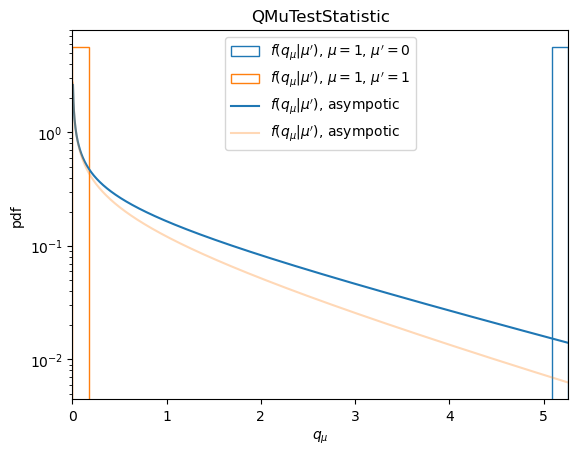

In [12]:
from titrate.plotting import ValidationPlotter
import matplotlib.pyplot as plt

ValidationPlotter(meas_dataset, '/Users/stefan/Downloads/results.h5', statistic='qmu', channel='b', mass=50*u.TeV)
plt.savefig('/Users/stefan/Downloads/qmu_validation.pdf')

## QTildeMuTestStatistic

In [14]:
validator_tilde = AsymptoticValidator(meas_dataset, statistic='qtildemu', poi_name='scale')

In [15]:
validator_tilde.validate(n_toys=500)

{'pvalue_diff': 0.8921298305448861,
 'pvalue_same': 0.9424034682344796,
 'valid': True}

In [17]:
validator_tilde.write('/Users/stefan/Downloads/results.h5', overwrite=True)

In [18]:
validator_tilde_h5 = AsymptoticValidator(meas_dataset, path='/Users/stefan/Downloads/results.h5', statistic='qtildemu',channel='b', mass=50*u.TeV)

In [19]:
validator_tilde_h5.validate()

{'pvalue_diff': 0.8921298305448861,
 'pvalue_same': 0.9424034682344796,
 'valid': True}

/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:282: RuntimeWarning: divide by zero encountered in divide
  1
/Users/stefan/Documents/projects/TITRATE/titrate/statistics.py:269: RuntimeWarning: divide by zero encountered in divide
  1 / (2 * np.sqrt(2 * np.pi * ts_val)) * np.exp(-0.5 * ts_val),


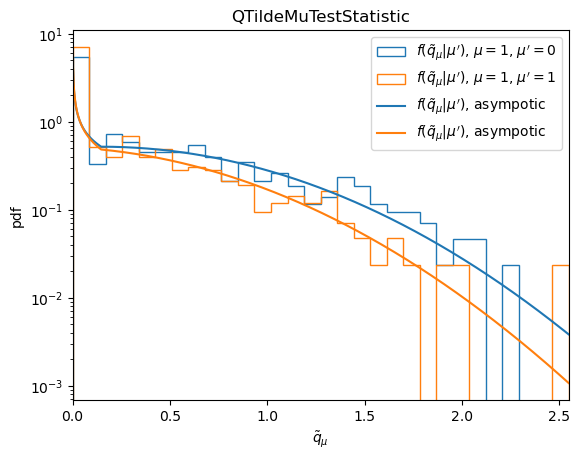

In [20]:
ValidationPlotter(meas_dataset, '/Users/stefan/Downloads/results.h5', statistic='qtildemu', channel='b', mass=50*u.TeV)
plt.savefig('/Users/stefan/Downloads/qtildemu_validation.pdf')

# Calculating Upper Limits

In [21]:
jfactory = JFactory(
    geom=geometry2d(),
    profile=ursa_major_ii_profile(),
    distance=ursa_major_ii_profile().DISTANCE_GC,
)
jfactor = jfactory.compute_differential_jfactor()
jfact_map = WcsNDMap(geom=geometry2d(), data=jfactor.value, unit=jfactor.unit)
spatial_model = TemplateSpatialModel(jfact_map, normalize=False)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [22]:
from titrate.upperlimits import ULFactory

In [23]:
ulfactory = ULFactory(meas_dataset, ['b', 'W', 'tau', 'mu'], 0.1*u.TeV, 100*u.TeV, 20, jfact_map)

In [24]:
ulfactory.compute()

In [25]:
ulfactory.write('/Users/stefan/Downloads/results.h5', overwrite=True)

In [26]:
from titrate.plotting import UpperLimitPlotter

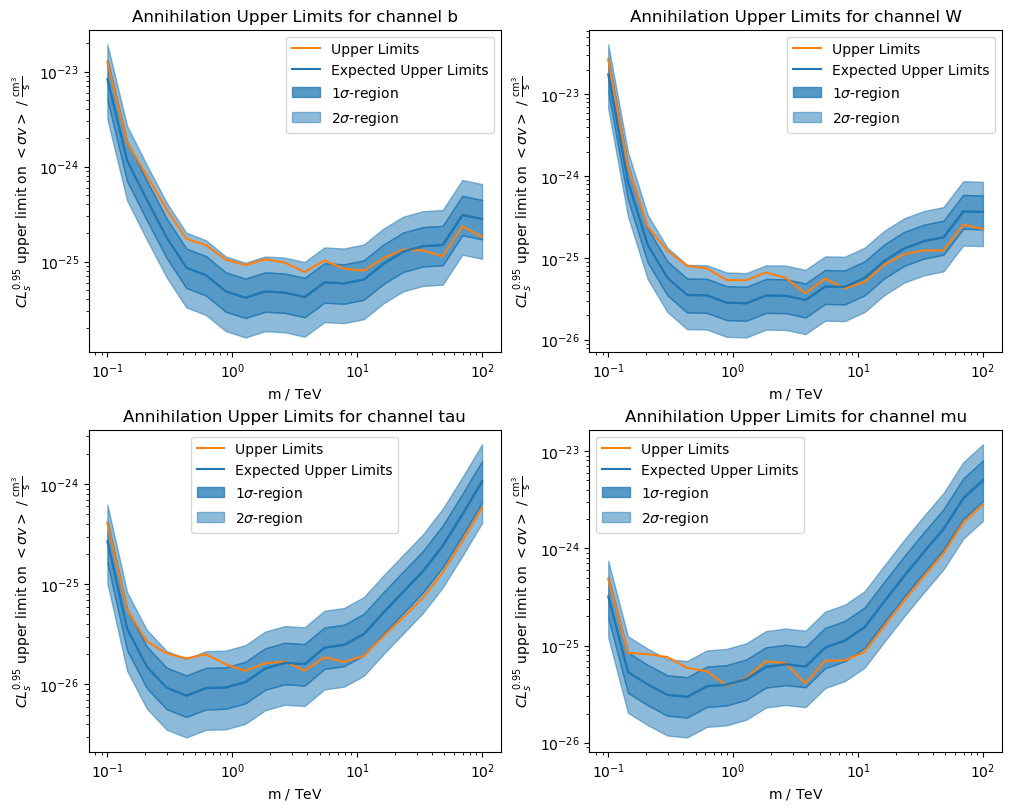

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8),layout='constrained')

for channel, ax in zip(['b', 'W', 'tau', 'mu'], np.array(axs).reshape(-1)):
    UpperLimitPlotter('/Users/stefan/Downloads/results.h5', channel=channel, ax=ax)
fig.savefig('/Users/stefan/Downloads/upperlimits.pdf')